In [1]:
%matplotlib inline
# Load all necessary packages
# import sys
# sys.path.append("../")
import numpy as np
from tqdm import tqdm

import sklearn

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import random

from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer
import xgboost as xgboost
from itertools import cycle, islice

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
import random
import numpy as np
import pandas as pd
def train_classifier(train_dataset, test_dataset, model, threshold=0.5, random_seed=None):
    """
    Trains a classification model, normalizes the data, and evaluates its performance.
    """
    # Set the random seed for reproducibility
    if random_seed is not None:
        random.seed(random_seed)  # For Python's random module
        np.random.seed(random_seed)  # For NumPy

    # Initialize the standard scaler
    scaler = StandardScaler()
    
    # 1. Normalize the training data
    X_train = scaler.fit_transform(train_dataset.features)  # Normalize the features
    y_train = train_dataset.labels.ravel()  # Extract target labels
    w_train = train_dataset.instance_weights.ravel()  # Extract instance weights (if available)

    # 2. Train the model
    # Use the random seed if the model supports the 'random_state' parameter
    classifier = model(random_state=random_seed) if 'random_state' in model().get_params() else model()
    classifier.fit(X_train, y_train, sample_weight=w_train)
    
    # 3. Predictions on the training set
    y_train_pred = classifier.predict(X_train)
    
    # Identify the positive class (e.g., income > 50K)
    pos_ind = np.where(classifier.classes_ == train_dataset.favorable_label)[0][0]

    # 4. Prepare the testing data
    X_test = scaler.transform(test_dataset.features)  # Normalize the test features
    y_test = test_dataset.labels  # Extract the actual test labels
    
    # Predict probabilities for the positive class
    test_scores = classifier.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)
    
    # Convert scores into binary predictions using the specified threshold
    y_test_pred = (test_scores > threshold).astype(int)
    
    # Compute main evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)

    # Display a preview of the first 10 probability scores
    print("Test set scores (first 10 predictions):")
    print(test_scores[:10])
    
    # Prepare the metrics as a pandas DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall'],
        'Value': [accuracy, precision, recall]
    })
    
    # Return the trained model and the metrics DataFrame
    return classifier, metrics_df, y_test_pred

1. - Preprocess the data
- binarize Age. 
- Split the data into train, validation, test sets
- train a classifier
- Measure the performance of the classifier on the test set. 

In [3]:
random_seed = 42
# A -------------------------------- Import dataaset and binarize age ----------------------------------------------

# Import dataset
dataset_orig = AdultDataset()
print(dataset_orig)
# Convert to dataframe to visualize it
data, _ = dataset_orig.convert_to_dataframe()
# Copy only to binarize age (Threshold = 40 years)
binarised = data.copy()
binarised['age'] = binarised['age'].apply(lambda x: 0 if x <= 35 else 1) # 1 if greater than 40
# B ----------------------------- Split into train, validation and test --------------------------------------------
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)
# C ----------------------------- Train a classifier and check for the predictions, and the performances --------------------------------------------
the_classifier, metrics_of_the_classifer, y_test_predictions = train_classifier(train_dataset=dataset_orig_train,
                                                            test_dataset= dataset_orig_test,
                                                            model=LogisticRegression,
                                                            threshold=0.5,
                                                            random_seed=random_seed)
print("\nEvaluation of the classifier's metrics:")
print(metrics_of_the_classifer)
binarised

               instance weights features                                    \
                                                       protected attribute   
                                     age education-num                race   
instance names                                                               
0                           1.0     25.0           7.0                 0.0   
1                           1.0     38.0           9.0                 1.0   
2                           1.0     28.0          12.0                 1.0   
3                           1.0     44.0          10.0                 0.0   
5                           1.0     34.0           6.0                 1.0   
...                         ...      ...           ...                 ...   
48837                       1.0     27.0          12.0                 1.0   
48838                       1.0     40.0           9.0                 1.0   
48839                       1.0     58.0           9.0          

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,...,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
0,0,7.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,9.0,1.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,12.0,1.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,10.0,0.0,1.0,7688.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0,6.0,1.0,1.0,0.0,0.0,30.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0,12.0,1.0,0.0,0.0,0.0,38.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48838,1,9.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
48839,1,9.0,1.0,0.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48840,0,9.0,1.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


2. - Assess the group fairness of the classifier, assuming the protected attributes are Age, Sex. 
- apply a technique to ensure the classifier is fair.

In [4]:
random_seed = 42
random.seed(random_seed) 
np.random.seed(random_seed)

# A -------- Assess the group fairness of the classifier, assuming the protected attributes are Age, Sex ------------ 

privileged_groups = [{'sex': 1}]  # Men are priviledged
unprivileged_groups = [{'sex': 0}]  

test_predicted = dataset_orig_test.copy()
test_predicted.labels = y_test_predictions  # Prédictions du classifier

print("\nInstance weights before reweighting:")
print(test_predicted.instance_weights[:10])  
# Compute fairness of the classifier (test set)
metric_test_classifier = BinaryLabelDatasetMetric(test_predicted, 
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups)

display(Markdown("#### Test set fairness metrics (classifier):"))
print("Statistical Parity Difference (classifier):", metric_test_classifier.statistical_parity_difference())

# B ---------------- apply a technique to ensure the classifier is fair  ----------------------------------------------

RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)
dataset_train_transf = RW.fit_transform(dataset_orig_train)

print("\nInstance weights after reweighting:")
print(dataset_train_transf.instance_weights[:10])  

metric_transf_train = BinaryLabelDatasetMetric(dataset_train_transf, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
print("\n")
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups (Sex):")
print(metric_transf_train.statistical_parity_difference())

# C ------------------------- Train our 'fair classifier' on the new dataset ----------------------------------------------
fair_classifier, fair_metrics, y_test_pred_fair = train_classifier(
    train_dataset=dataset_train_transf,  # Transformed dataset
    test_dataset=dataset_orig_test,      # Same test dataset
    model=LogisticRegression,
    threshold=0.5,
    random_seed=42
)
# Display metrics for the fair classifier
print("\nFair Classifier Metrics:")
print(fair_metrics)


Instance weights before reweighting:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


#### Test set fairness metrics (classifier):

Statistical Parity Difference (classifier): -0.1791808994322599

Instance weights after reweighting:
[0.8495325  0.8495325  0.79519764 1.0919902  0.79519764 0.8495325
 1.0919902  0.8495325  1.0919902  1.0919902 ]




#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups (Sex):
-5.551115123125783e-17
Test set scores (first 10 predictions):
[[2.79082008e-01]
 [3.67524754e-01]
 [2.53219917e-03]
 [7.95302236e-02]
 [4.72089290e-01]
 [7.32040872e-02]
 [4.45373052e-01]
 [6.67399864e-01]
 [3.65179183e-04]
 [1.91989594e-01]]

Fair Classifier Metrics:
      Metric     Value
0   Accuracy  0.841981
1  Precision  0.735981
2     Recall  0.563170


## Comparison of the metrics for both classifiers

In [5]:
# Display metrics for the main classifier
print("\nMain Classifier Metrics:")
print(metrics_of_the_classifer)

# Display metrics for the fair classifier
print("\nFair Classifier Metrics:")
print(fair_metrics)


Main Classifier Metrics:
      Metric     Value
0   Accuracy  0.848614
1  Precision  0.732003
2     Recall  0.612038

Fair Classifier Metrics:
      Metric     Value
0   Accuracy  0.841981
1  Precision  0.735981
2     Recall  0.563170


# 3 - Privacy :
- Cross tabulation showing the nb of persons for each combinations of Age and Sexe

In [6]:
import pandas as pd

cross_tab = pd.crosstab(index=binarised['age'],  # Age (0=young, 1=Aged)
                        columns=binarised['sex'],  # Sex (0=Women, 1=Men)
                        rownames=['Age'],
                        colnames=['Sex'])

cross_tab['Total'] = cross_tab.sum(axis=1)  
cross_tab.loc['Total'] = cross_tab.sum(axis=0)  

# Afficher la cross-tabulation
print("\nCross-tabulation of Age and Sex:")
cross_tabulation_frame = pd.DataFrame(cross_tab)

print(f"There are {cross_tab[0.0][0]} young females (Age=0, Sex=0.0).")
print(f"There are {cross_tab[1.0][0]} young males (Age=0, Sex=1.0).")
print(f"There are {cross_tab[0.0][1]} aged females (Age=1, Sex=0.0).")
print(f"There are {cross_tab[1.0][1]} aged males (Age=1, Sex=1.0).")

print(f"Total young people (Age=0): {cross_tab['Total'][0]}.")
print(f"Total aged people (Age=1): {cross_tab['Total'][1]}.")

print(f"Total females (Sex=0.0): {cross_tab[0.0]['Total']}.")
print(f"Total males (Sex=1.0): {cross_tab[1.0]['Total']}.")
print(f"Grand total: {cross_tab['Total']['Total']}.")

cross_tabulation_frame


Cross-tabulation of Age and Sex:
There are 7462 young females (Age=0, Sex=0.0).
There are 13053 young males (Age=0, Sex=1.0).
There are 7233 aged females (Age=1, Sex=0.0).
There are 17474 aged males (Age=1, Sex=1.0).
Total young people (Age=0): 20515.
Total aged people (Age=1): 24707.
Total females (Sex=0.0): 14695.
Total males (Sex=1.0): 30527.
Grand total: 45222.


Sex,0.0,1.0,Total
Age,,,
0,7462,13053,20515
1,7233,17474,24707
Total,14695,30527,45222


B - Local differential privacy on age and sex and generation of a new noisy dataset

In [7]:
import random

def rand_resp(x, p=0.75, q=0.75):
    toss = random.random()
    if x == 0:
        y = 0 if toss <= q else 1
    else:
        y = 1 if toss <= p else 0
    return y

Create a new noisy dataset for these attributes
and
Visualize the results (Test with various epsilon and quantify the divergence for each value) 

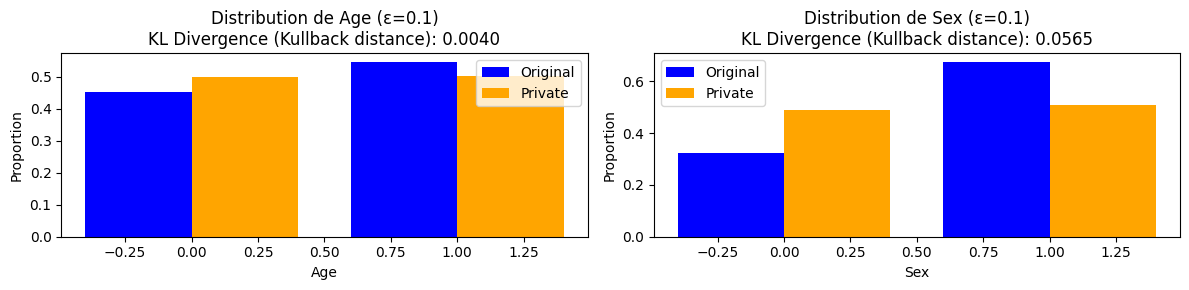

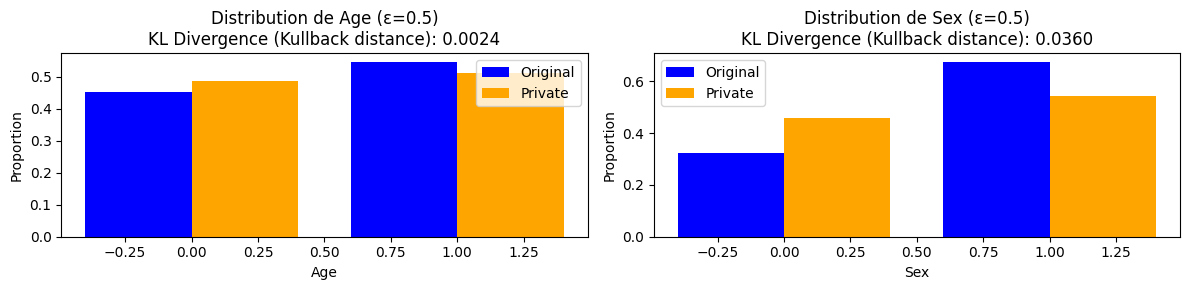

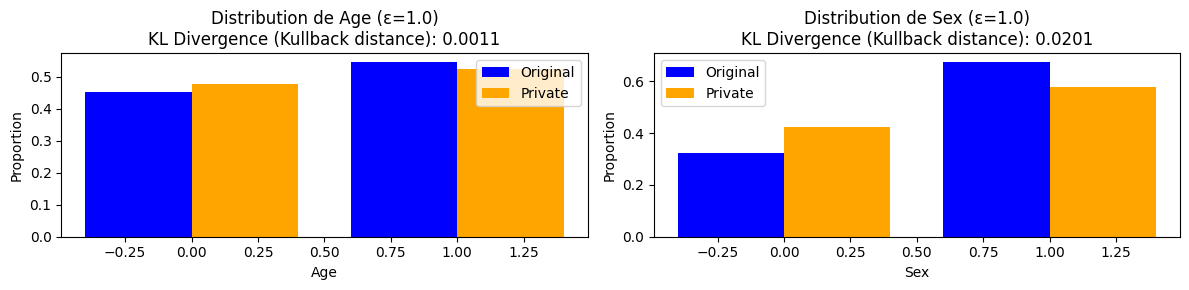

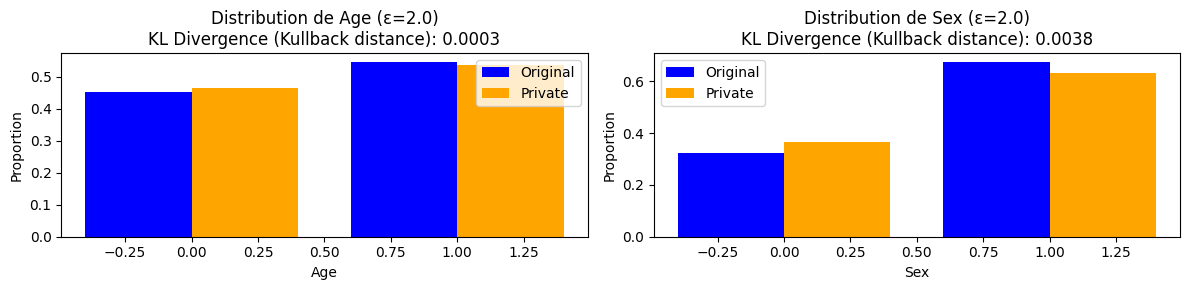

In [8]:
import matplotlib.pyplot as plt
import numpy as np

epsilon_values = [0.1, 0.5, 1.0, 2.0]
from scipy.stats import entropy

def kl_divergence(original_dist, private_dist):
    """
    Compute the kullback distance between the two distributions. 
    """
    # Normalise
    original_dist = original_dist / original_dist.sum()
    private_dist = private_dist / private_dist.sum()
    
    return entropy(original_dist, private_dist)

def plot_distribution(original_data, private_data, epsilon):
    attributes = ['age', 'sex'] # Attributes to compare

    plt.figure(figsize=(12, 3)) 

    for i, att in enumerate(attributes, start=1): 
        original_dist = original_data[att].value_counts(normalize=True)
        private_dist = private_data[att].value_counts(normalize=True)
        
        kl_div = kl_divergence(original_dist, private_dist)

        plt.subplot(1, 2, i) 
        plt.bar(original_dist.index - 0.2, original_dist, width=0.4, label='Original', color='blue')
        plt.bar(private_dist.index + 0.2, private_dist, width=0.4, label='Private', color='orange')

        plt.xlabel(att.capitalize())
        plt.ylabel('Proportion')
        plt.title(f'Distribution de {att.capitalize()} (ε={epsilon})\nKL Divergence (Kullback distance): {kl_div:.4f}')
        plt.legend()

    plt.tight_layout()
    plt.show()

for epsilon in epsilon_values:
    p, q = np.exp(epsilon) / (1 + np.exp(epsilon)), np.exp(epsilon) / (1 + np.exp(epsilon))
    
    # Copy of the noisy dataset
    binarised_private = binarised.copy()
    binarised_private['age'] = binarised['age'].apply(lambda x: rand_resp(x, p, q))
    binarised_private['sex'] = binarised['sex'].apply(lambda x: rand_resp(x, p, q))
    
    # Plot the histograms with metric of divergence
    plot_distribution(binarised, binarised_private, epsilon)

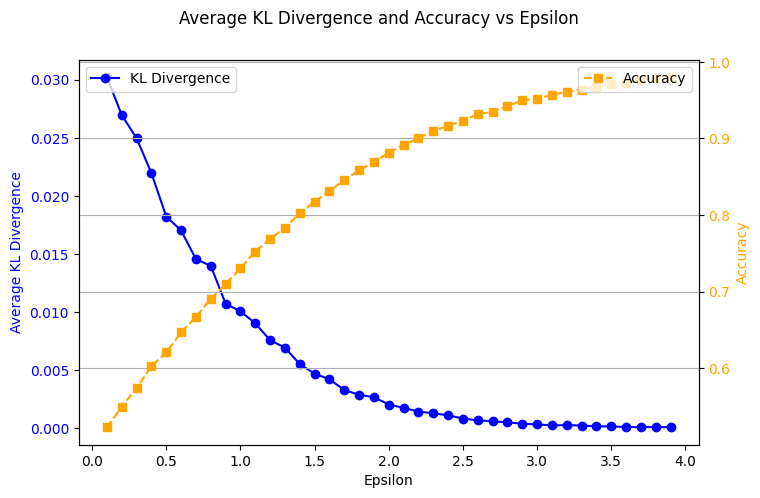

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy

np.random.seed(42)

epsilon_values = np.arange(0.1, 4.0, 0.1)

def kl_divergence(original_dist, private_dist):
    """
    Kullback-Leibler.
    """
    original_dist = original_dist / original_dist.sum()
    private_dist = private_dist / private_dist.sum()
    return entropy(original_dist, private_dist)

def calculate_accuracy(original_data, private_data, attributes):
    """
    Accuracy : proportion of valeurs identical values between original and private
    """
    total_matches = 0
    total_values = 0

    for att in attributes:
        matches = (original_data[att] == private_data[att]).sum()
        total_matches += matches
        total_values += len(original_data[att])

    return total_matches / total_values  

kl_values = []
accuracy_values = []

for epsilon in epsilon_values:
    p, q = np.exp(epsilon) / (1 + np.exp(epsilon)), np.exp(epsilon) / (1 + np.exp(epsilon))
    
    binarised_private = binarised.copy()
    binarised_private['age'] = binarised['age'].apply(lambda x: rand_resp(x, p, q))
    binarised_private['sex'] = binarised['sex'].apply(lambda x: rand_resp(x, p, q))
    
    # Compute mean divergence 
    attributes = ['age', 'sex']
    avg_kl = sum(
        kl_divergence(
            binarised[att].value_counts(normalize=True),
            binarised_private[att].value_counts(normalize=True)
        )
        for att in attributes
    ) / len(attributes)
    kl_values.append(avg_kl)

    # Compute accuracy
    accuracy = calculate_accuracy(binarised, binarised_private, attributes)
    accuracy_values.append(accuracy)

fig, ax1 = plt.subplots(figsize=(8, 5))

# First axe for KL divergence
ax1.set_xlabel('Epsilon')
ax1.set_ylabel('Average KL Divergence', color='blue')
ax1.plot(epsilon_values, kl_values, marker='o', linestyle='-', color='blue', label='KL Divergence')
ax1.tick_params(axis='y', labelcolor='blue')

# Second axe for Accruacy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='orange')
ax2.plot(epsilon_values, accuracy_values, marker='s', linestyle='--', color='orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle('Average KL Divergence and Accuracy vs Epsilon')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()

- Cross tabulation for private dataset and quantify the errors in the estimations

In [10]:
import pandas as pd
import numpy as np
random.seed(42)
np.random.seed
epsilon = 1.0 # Choose epsilon of 1 

def rand_resp(x, p=0.75, q=0.75):
    toss = random.random()
    if x == 0:
        y = 0 if toss <= q else 1
    else:
        y = 1 if toss <= p else 0
    return y

p = np.exp(epsilon) / (1 + np.exp(epsilon))
q = 1 / (1 + np.exp(epsilon))

binarised_noisy_e1 = binarised.copy()  
binarised_noisy_e1['age'] = binarised['age'].apply(lambda x: rand_resp(x, p, q))
binarised_noisy_e1['sex'] = binarised['sex'].apply(lambda x: rand_resp(x, p, q))

original_crosstab = pd.crosstab(binarised['age'], binarised['sex'], margins=True)

noisy_crosstab = pd.crosstab(binarised_noisy_e1['age'], binarised_noisy_e1['sex'], margins=True)

error_matrix = abs(original_crosstab - noisy_crosstab)

mae = error_matrix.mean().mean()  # Mean Absolute Error
rmse = ((error_matrix**2).mean().mean())**0.5  # Root Mean Squared Error

print(f"Cross-tabulation for original data (Epsilon = {epsilon}):")
print(original_crosstab)

print(f"\nCross-tabulation for private data (Epsilon = {epsilon}):")
print(noisy_crosstab)

print("\nMatrix of errors for epsilon=1 :")
print(error_matrix)

print(f"\nMetrics:")
print(f"Mean Absolute Error (MAE) : {mae:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.4f}")

Cross-tabulation for original data (Epsilon = 1.0):
sex    0.0    1.0    All
age                     
0     7462  13053  20515
1     7233  17474  24707
All  14695  30527  45222

Cross-tabulation for private data (Epsilon = 1.0):
sex      0      1    All
age                     
0     3305   8800  12105
1     8948  24169  33117
All  12253  32969  45222

Matrix of errors for epsilon=1 :
sex   0.0   1.0   All
age                  
0    4157  4253  8410
1    1715  6695  8410
All  2442  2442     0

Metrics:
Mean Absolute Error (MAE) : 4280.4444
Root Mean Squared Error (RMSE) : 5126.3571


In [11]:
from aif360.datasets import BinaryLabelDataset
import pandas as pd
data_priv = binarised_noisy_e1
private_data = data_priv.copy()
private_dataset = BinaryLabelDataset(
    favorable_label=1.0,               
    unfavorable_label=0.0,              
    df=private_data,                   
    label_names=['income-per-year'],   
    protected_attribute_names=['age', 'sex']  
)

In [12]:
# 1. Split the private dataset into train (70%), validation (15%), and test (15%)
private_train, private_vt = private_dataset.split([0.7], shuffle=True)  # 70% train
private_valid, private_test = private_vt.split([0.5], shuffle=True)  # 15% validation, 15% test

# 2. Train the private classifier using the train split
private_classifier, private_metrics, private_test_pred = train_classifier(
    train_dataset=private_train,
    test_dataset=private_test,
    model=LogisticRegression,
    threshold=0.5,
    random_seed=42
)

Test set scores (first 10 predictions):
[[0.03323432]
 [0.01074711]
 [0.09354151]
 [0.61013986]
 [0.54278804]
 [0.499151  ]
 [0.02531446]
 [0.00433407]
 [0.00094822]
 [0.34374392]]


Measure the performance of the private classifier. Is there an impact on model performance
due to privacy compared to the classifier?

In [13]:
print("Classifier's metrics", metrics_of_the_classifer)
print("Private classifier's metric", private_metrics)

Classifier's metrics       Metric     Value
0   Accuracy  0.848614
1  Precision  0.732003
2     Recall  0.612038
Private classifier's metric       Metric     Value
0   Accuracy  0.843897
1  Precision  0.726415
2     Recall  0.594771


## Task 4: Privacy and Fairness
### Applying Fairness Mitigation to Private Data

In [14]:
# 1 - Create the fair_private classifier

# A - Apply the reweighting on the private dataset to have the private + fair dataset

RW_private = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
private_fair_dataset = RW_private.fit_transform(private_train)

# B - Split into train, val, test

private_fair_train, private_fair_vt = private_fair_dataset.split([0.7], shuffle=True)  # 70% train
private_fair_valid, private_fair_test = private_fair_vt.split([0.5], shuffle=True)  # 15% validation, 15% test

# C - Train the classifier and look at 10 first predictions

private_fair_classifier, private_fair_metrics, private_fair_test_pred = train_classifier(
    train_dataset=private_fair_train,  # Ensemble train privé et équitable
    test_dataset=private_fair_test,    # Ensemble test pour évaluation
    model=LogisticRegression,
    threshold=0.5,
    random_seed=42
)



Test set scores (first 10 predictions):
[[4.75806995e-04]
 [2.42862526e-01]
 [1.14374857e-01]
 [2.81689296e-01]
 [7.12886662e-01]
 [7.56199759e-03]
 [6.04446561e-01]
 [4.64344381e-03]
 [6.61826933e-01]
 [2.83844181e-02]]


### Step 2 : Comparing the performances for :
-   private + fair (With correction)
-   Fair classifier (Non noisy data, but bias corrected)

In [15]:
print("Private + Fair classifier's metrics : \n", private_fair_metrics)
print("Fair classifier's metrics : \n", fair_metrics)

Private + Fair classifier's metrics : 
       Metric     Value
0   Accuracy  0.845862
1  Precision  0.734778
2     Recall  0.599832
Fair classifier's metrics : 
       Metric     Value
0   Accuracy  0.841981
1  Precision  0.735981
2     Recall  0.563170


In [16]:
# Data preprocessing to train model

tabular_data = Tabular(
   private_data,
   #categorical_columns=["age","sex"],
   target_column='income-per-year'
)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)

# display(type(tabular_data[0]))

# Split into training and test datasets
train, test, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.70,random_state = 1234)



test_labels = test_labels.astype(int)


# Train an LogisticRegression model
model_private_tabular = LogisticRegression(max_iter=1000)
model_private_tabular.fit(train, train_labels)


predict_function=lambda z: model_private_tabular.predict_proba(transformer.transform(z))


# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
test_df = test_data.to_pd()
test_df["label"] = test_labels
predictions = model_private_tabular.predict(test)
test_df["prediction"] = predictions


In [18]:
# Local expl
explainers = TabularExplainer(
  explainers=['lime'],                       # The explainers to apply
  mode="classification",                             # The task type
  data=train_data,                                   # The data for initializing the explainers
  model=model_private_tabular,                                       # The ML model to explain
  preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
)


In [19]:
instance_ids = []


for i in range(len(test_labels)):
    if test_labels[i] != predictions[i] and model_private_tabular.predict_proba(test[i:i+1])[0][int(predictions[i])] > 0.8:
        instance_ids.append(i)



n_instances = len(instance_ids)

test_instances = test_data[instance_ids]
local_explanations = explainers.explain(X=test_instances)

wrong_feature = []

for i, instance_id in enumerate(instance_ids):
    #print(f"Instance {instance_id} has label {test_labels[instance_id]} and prediction {predictions[instance_id]}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
    explanation = local_explanations["lime"].get_explanations(index = i)
    
    wf = explanation["features"][np.argmax(explanation["scores"])]
    wv = explanation["values"][np.argmax(explanation["scores"])]
    #print(explanation["features"][np.argmax(explanation["scores"])])
    if [wf,predictions[instance_id],wv] not in wrong_feature:
        wrong_feature.append([wf,predictions[instance_id],wv])



print("Here are all the wrong features: ", wrong_feature)
print("The total number of elements with a confident wrong prediction: ", n_instances)

Here are all the wrong features:  [['capital-gain', 0.0, 0.0], ['marital-status=Never-married', 1.0, 0.0], ['capital-loss', 0.0, 0.0], ['native-country=Hungary', 1.0, 0.0], ['marital-status=Married-AF-spouse', 0.0, 0.0], ['capital-gain', 1.0, 3781.0], ['native-country=Columbia', 1.0, 0.0], ['capital-gain', 1.0, 3137.0], ['native-country=Peru', 1.0, 0.0], ['capital-gain', 1.0, 10566.0], ['education=Prof-school', 1.0, 1.0], ['capital-gain', 1.0, 2829.0], ['capital-loss', 1.0, 1628.0], ['capital-loss', 1.0, 1672.0], ['capital-gain', 1.0, 1173.0], ['capital-gain', 1.0, 5013.0], ['capital-loss', 1.0, 2002.0], ['capital-gain', 1.0, 3818.0], ['marital-status=Never-married', 0.0, 1.0], ['capital-gain', 1.0, 34095.0], ['capital-gain', 1.0, 3908.0], ['workclass=Without-pay', 1.0, 0.0], ['native-country=Cambodia', 1.0, 0.0], ['capital-loss', 1.0, 2267.0], ['capital-gain', 1.0, 41310.0], ['marital-status=Married-AF-spouse', 1.0, 0.0], ['native-country=Yugoslavia', 1.0, 0.0], ['native-country=Hondu

## Full dataset

In [20]:
# Data preprocessing to train model


tabular_data = Tabular(
   data,
   #categorical_columns=["age","sex"],
   target_column='income-per-year'
)



transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)




# display(type(tabular_data[0]))

# Split into training and test datasets
train, test, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.70,random_state = 1234)

test_labels = test_labels.astype(int)
predict_function=lambda z: model_private_tabular.predict_proba(transformer.transform(z))


# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

In [21]:
test_df = test_data.to_pd()
test_df["label"] = test_labels
predictions = model_private_tabular.predict(test)
test_df["prediction"] = predictions

In [22]:
# Local expl
explainers = TabularExplainer(
  explainers=['lime'],                       # The explainers to apply
  mode="classification",                             # The task type
  data=train_data,                                   # The data for initializing the explainers
  model=model_private_tabular,                                       # The ML model to explain
  preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs

)

In [23]:
instance_ids = []


for i in range(len(test_labels)):
    if test_labels[i] != predictions[i] and model_private_tabular.predict_proba(test[i:i+1])[0][int(predictions[i])] > 0.8:
        instance_ids.append(i)



n_instances = len(instance_ids)

test_instances = test_data[instance_ids]
local_explanations = explainers.explain(X=test_instances)

wrong_feature = []

for i, instance_id in enumerate(instance_ids):
    #print(f"Instance {instance_id} has label {test_labels[instance_id]} and prediction {predictions[instance_id]}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
    explanation = local_explanations["lime"].get_explanations(index = i)
    
    wf = explanation["features"][np.argmax(explanation["scores"])]
    wv = explanation["values"][np.argmax(explanation["scores"])]
    #print(explanation["features"][np.argmax(explanation["scores"])])
    if [wf,predictions[instance_id],wv] not in wrong_feature:
        wrong_feature.append([wf,predictions[instance_id],wv])



print("Here are all the wrong features: ", wrong_feature)
print("The total number of elements with a confident wrong prediction:", n_instances)

Here are all the wrong features:  [['workclass=Without-pay', 1.0, 0.0], ['age', 1.0, 52.0], ['age', 1.0, 56.0], ['relationship=Own-child', 1.0, 0.0], ['native-country=France', 1.0, 0.0], ['age', 1.0, 66.0], ['capital-gain', 1.0, 6849.0], ['age', 1.0, 55.0], ['age', 1.0, 60.0], ['age', 1.0, 73.0], ['age', 1.0, 51.0], ['marital-status=Married-AF-spouse', 1.0, 0.0], ['age', 1.0, 53.0], ['native-country=Scotland', 1.0, 0.0], ['native-country=Honduras', 1.0, 0.0], ['native-country=Hong', 1.0, 0.0], ['native-country=Laos', 1.0, 0.0], ['native-country=Cambodia', 1.0, 0.0], ['age', 1.0, 49.0], ['age', 1.0, 57.0], ['marital-status=Never-married', 1.0, 0.0], ['age', 1.0, 61.0], ['age', 1.0, 65.0], ['occupation=Other-service', 1.0, 0.0], ['age', 1.0, 54.0], ['age', 1.0, 48.0], ['native-country=Peru', 1.0, 0.0], ['native-country=Haiti', 1.0, 0.0], ['age', 1.0, 68.0], ['age', 1.0, 59.0], ['native-country=Taiwan', 1.0, 0.0], ['native-country=Guatemala', 1.0, 0.0], ['age', 1.0, 50.0], ['capital-gain'

# Explainability and llms

In [24]:
print(type(private_fair_dataset))
private_fair_data = private_fair_dataset.convert_to_dataframe()

if isinstance(private_fair_data, dict):
    print(private_fair_data)  # Diagnostiquer la structure

    # Conversion selon le type de dictionnaire
    try:
        private_fair_data = pd.DataFrame(private_fair_data)
    except ValueError:
        private_fair_data = pd.DataFrame.from_dict(private_fair_data, orient="index")


#df = pd.DataFrame(private_fair_dataset, columns=private_fair_dataset.columns)
data, metadata = private_fair_dataset.convert_to_dataframe()


private_fair_data = pd.DataFrame(data)
private_fair_data
print(type(private_fair_data))
private_fair_data

<class 'aif360.datasets.binary_label_dataset.BinaryLabelDataset'>
<class 'pandas.core.frame.DataFrame'>


,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,...,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
21762,0.0,6.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21701,1.0,9.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
42663,1.0,11.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
42694,1.0,10.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13590,1.0,9.0,1.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9222,1.0,12.0,1.0,1.0,0.0,0.0,37.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9786,0.0,9.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16223,1.0,9.0,1.0,1.0,0.0,0.0,35.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
43519,1.0,10.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
# Data preprocessing to train model

tabular_data = Tabular(
   private_fair_data,
   #categorical_columns=["age","sex"],
   target_column='income-per-year'
)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)

# display(type(tabular_data[0]))

# Split into training and test datasets
train, test, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.70,random_state = 1234)

test_labels = test_labels.astype(int)


# Train an LogisticRegression model
model_private_fair_tabular = LogisticRegression(max_iter=10000)
model_private_fair_tabular.fit(train, train_labels)


predict_function=lambda z: model_private_fair_tabular.predict_proba(transformer.transform(z))


# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)


unique_test contains one line simulating one user

In [26]:
test_df = test_data.to_pd()
test_df["label"] = test_labels
predictions = model_private_fair_tabular.predict(test)
test_df["prediction"] = predictions

In [27]:
# Local expl
explainers = TabularExplainer(
  explainers=['lime'],                       # The explainers to apply
  mode="classification",                             # The task type
  data=train_data,                                   # The data for initializing the explainers
  model=model_private_fair_tabular,                                       # The ML model to explain
  preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
)

instance_ids = [0]
n_instances = len(instance_ids)

test_instances = test_data[instance_ids]
local_explanations = explainers.explain(X=test_instances)

In [28]:



top_feature = []

for i, instance_id in enumerate(instance_ids):
    explanation = local_explanations["lime"].get_explanations(index = i)
    
    tf = explanation["features"][np.argmax(explanation["scores"])]
    tv = explanation["values"][np.argmax(explanation["scores"])]
    if [tf,predictions[instance_id],tv] not in top_feature:
        top_feature.append([tf,predictions[instance_id],tv])


prediction_message = "<50k" if top_feature[0][1] == 0 else ">=50k"

feature_message = "Predictions : " + prediction_message +  " atribute : " + str(top_feature[0][0]) + " = " + str(top_feature[0][2])


In [33]:
print(feature_message)


Predictions : <50k atribute : capital-gain = 0.0


In [34]:
from openai import OpenAI

client = OpenAI(
    api_key="your-api-key",
    base_url="http://localhost:1234/v1"
)

In [35]:
messages = [
    {"role": "system", "content": "from now on when i give you a prediction and attributs/value pairs i want you to write a correct explanation phrase where the prediction is based on the given attributes and values write it in good english and make look good for a userdo not write the name of the attributes"}
]

def get_response(message, messages):
    messages.append({"role": "user", "content": message})
    completion = client.chat.completions.create(
        messages=messages,
        temperature=0.8,
        model="model"
    )
    response = completion.choices[0].message.content
    messages.append({"role": "assistant", "content": response})
    return response, messages

In [36]:
response, messages = get_response(feature_message, messages)
print(response)

Based on the attribute "capital gain", I predict that the predicted value will be **-30,000**.

The reason is that a capital gain of **0.0** suggests that there are no expected profits or returns from an investment. It may indicate that the investment has lost money, or that it's not generating any significant revenue or income. This could be due to various factors such as market conditions, competition, or internal issues within the company.
